<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_phase1_covid19_case_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの確認/読み込み


## データの読み込み

In [818]:
!pip install japanize_matplotlib category_encoders xgboost optuna shap

In [819]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve, BaseCrossValidator
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from oauth2client.client import GoogleCredentials
from google.colab import auth
import warnings
import xgboost as xgb
from IPython.display import clear_output
import optuna
import functools
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import shap
from pprint import pprint
from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
shap.initjs()
auth.authenticate_user()

In [820]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [821]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [822]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


## データの確認

In [823]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1852,3232,229
top,13,1,21-150,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11871,15934,12264,12265,13890


## データクリーニング


In [824]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]

In [825]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [826]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## 症状のデータの読み込み

In [827]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1tnxt17rtmFnG4UNX8DXVXGUhCcL7-cXHE3hhoOpvfsk/edit#gid=577718303'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [828]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
168518,13,43933,13-43933,非公表,-,-,-
168520,13,43934,13-43934,非公表,-,-,-
168522,13,43935,13-43935,非公表,-,-,-
168524,13,43936,13-43936,非公表,-,-,-
168526,13,43937,13-43937,非公表,-,-,-


In [829]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [830]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [831]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [832]:
#不要な要素を取り除く
# 検査しないとわからない項目は取り除く
# 今回は死亡、受診、入院、退院、肺炎を取り除く
# 追加で呼吸困難は影響が大きすぎるので排除する
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "死亡" in element):
    if not ("入院" in element or "肺炎" in element or "退院" in element or "呼吸困難" in element):
        cleaned_symptoms_list.append(element)

In [833]:
cleaned_symptoms_list

['',
 '血尿',
 '湿疹',
 '糖尿病',
 '動悸',
 '胸内苦悶',
 '喀痰',
 '不明熱',
 '摂食障害',
 '吐血',
 '胆石性急性胆のう炎',
 '鼻汁',
 '発汗障害',
 '嚥下障害',
 '腰痛症',
 '筋力低下',
 'そう痒',
 '味覚障害',
 '尿路感染症',
 '老衰',
 'めまい',
 '窒息感',
 '敗血症性ショック',
 '胸痛',
 '全身痛',
 'ぶどう球菌感染症',
 '悪心',
 '口内炎',
 '咽頭異常感症',
 '関節炎',
 '喉頭痛',
 '乾性咳',
 '息切れ',
 '喉頭炎',
 '拡張相肥大型心筋症',
 '急性耳痛',
 'アデノウイルス感染症',
 '寝汗',
 '高血圧症',
 '胸水貯留',
 '鼻閉',
 '下肢しびれ',
 'コロナウイルス感染症',
 '過剰喀痰',
 '眼精疲労',
 '悪寒戦慄',
 '腰殿部痛',
 '異常喀痰',
 '神経痛',
 '鼻閉感',
 '気管支炎',
 '不安障害',
 '咽頭炎',
 'しびれ感',
 '腰腹痛',
 '関節痛',
 '胸部不快感',
 '項部痛',
 '肩こり',
 '味覚減退症',
 '口渇症',
 '眼痛',
 '麻疹',
 '頭痛',
 '味覚異常',
 '骨折',
 '呼吸促迫',
 '疲労感',
 'ブラ',
 '聴覚異常',
 '扁桃炎',
 '悪寒',
 '結膜充血',
 '筋肉痛',
 '全身倦怠感',
 '血腫',
 'つかえ感',
 '胸やけ',
 '検診',
 '頭重感',
 '後頭部痛',
 '胸部異常陰影',
 '高熱',
 '咳',
 '項部腫脹',
 '急性鼻炎',
 '肝機能障害',
 '呼吸不全',
 '咽頭痛',
 '血痰',
 '咽喉頭異常感症',
 '健康相談',
 '体力低下',
 'かぜ',
 '乏尿',
 '片頭痛',
 '食欲不振',
 '歯痛',
 '振戦',
 '嘔気',
 '膿性痰',
 '鼻痛',
 '前胸部痛',
 '嗄声',
 '肋骨痛',
 '溶連菌感染症',
 '胃腸疾患',
 '外傷',
 '胃痛',
 '咽頭発赤',
 '倦怠感',
 'こむら返り',
 '歩行困難',
 '背部痛',
 '肩部痛',
 '結膜炎',
 '起立性眩暈',
 

# 勾配ブースティング法を用いたモデルの作成


## データの整理

In [834]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [835]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "1").str.replace("死亡", "1").str.replace("中等症", "0").str.replace("軽症", "0").str.replace("無症状", "0")
df_new["ステータス"] = df_new["ステータス"].astype(int)

In [836]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [837]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [838]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

## XGBoostを用いるケース

In [839]:
params1 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}

params2 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'auc',
}

In [840]:
def plot_xgboost_result(df):
  # モデルの作成(xgboost)
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=0)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
      params1,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  y_pred = model1.predict(dtest)
  y_true = y_test.values

  train_metric = evals_result['train']['mae']
  eval_metric = evals_result['test']['mae']
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
  axes[0,0].plot(train_metric, label='train mae')
  axes[0,0].plot(eval_metric, label='test mae', linestyle='dashed')
  axes[0,0].grid()
  axes[0,0].legend()
  axes[0,0].set_xlabel('学習回数')
  axes[0,0].set_ylabel('平均絶対誤差')

  xgb.plot_importance(model1, ax=axes[0,1], importance_type='gain', title='項目の重要度', show_values=False)
  axes[0,1].set_ylabel("項目")

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  # モデルの作成(AUC)
  model2 = xgb.train(
      params2,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  check = model2.predict(dtest)
  fpr, tpr, thresholds = roc_curve(y_true, check)
  axes[1,0].plot(fpr, tpr, marker='o')
  axes[1,0].set_xlabel('FPR: False positive rate')
  axes[1,0].set_ylabel('TPR: True positive rate')
  axes[1,0].grid()

  history = xgb.cv(params1, dtrain, num_boost_round=200, early_stopping_rounds=10, nfold=10, verbose_eval=False, stratified=True)
  train_metric = history['train-mae-mean']
  eval_metric = history['test-mae-mean']
  axes[1,1].plot(train_metric, label='train mae')
  axes[1,1].plot(eval_metric, label='eval mae', linestyle='dashed')
  axes[1,1].grid()
  axes[1,1].legend()
  axes[1,1].set_xlabel('round')
  axes[1,1].set_ylabel('mae')
  print("重症,死亡の患者の数", df['ステータス'].value_counts()[1], '-', df['ステータス'].value_counts()[0])
  print("AUCのベストスコア", model2.best_score)

In [841]:
def cross_validation(df, random_state = 0):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=random_state)
  model = LogisticRegression().fit(x_train, y_train)
  kf_with_shuffle = KFold(n_splits = 10, shuffle = True, random_state = random_state)
  kf_without_shuffle = KFold(n_splits = 10, shuffle = False, random_state = random_state)
  strat_kf_with_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  strat_kf_withøut_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  test_data_score = model.score(x_test, y_test)
  kfold_scores_with_shuffle = cross_val_score(model, x, y, cv=kf_with_shuffle)
  kfold_scores_without_shuffle = cross_val_score(model, x, y, cv=kf_without_shuffle)
  strat_kfold_score_with_shuffle = cross_val_score(model, x, y, cv=strat_kf_with_shuffle)
  strat_kfold_score_without_shuffle = cross_val_score(model, x, y, cv=strat_kf_withøut_shuffle)
  print("random_stateの値", random_state)
  print("テストデータのスコア", test_data_score)
  print("交差検証のスコア平均(シャッフルあり)", kfold_scores_with_shuffle.mean())
  print("交差検証のスコア平均(シャッフルなし)", kfold_scores_without_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルあり)", strat_kfold_score_with_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルなし)", strat_kfold_score_without_shuffle.mean())

In [842]:
# 重症患者の割合が少ないことから予測値が全て軽傷患者である判定をしてしまっている
# そのため不均衡データ分析を行う必要がある
# 今回はオーバーサンプリングとアンダーサンプリングの２種類を用いて不均衡なデータでも十分な分析ができるようにする

## LightGBMを用いるケース

In [843]:
# サンプリングレートを元に確率を補正する
def probability_calibration(y_proba, beta):
    calibrated_proba = y_proba / (y_proba + (1 - y_proba) / beta)
    return calibrated_proba

In [844]:
def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

In [845]:
def check_classification(df):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # まずは不均衡データのままロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train, y_train)
  # 検証用データを予測させる
  y_pred_proba_base = clf.predict_proba(X_test)[:, 1]
  y_pred_base = np.where(y_pred_proba_base > 0.163, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_base, percentage)

  # Under-sampling で均衡データにする
  sampler = RandomUnderSampler(random_state=42)
  X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

  # Over-sampling で均衡データにする
  over_sampler = SMOTE(random_state=42)
  X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

  # Under-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_sampled, y_train_sampled)
  # Under-samplingの検証用データを予測させる
  y_pred_proba_us = clf.predict_proba(X_test)[:, 1]
  y_pred_us = np.where(y_pred_proba_us > 0.163, 1, 0)


  # Over-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_over_sampled, y_train_over_sampled)
  # Over-samplingの検証用データを予測させる
  y_pred_proba_os = clf.predict_proba(X_test)[:, 1]
  y_pred_os = np.where(y_pred_proba_os > 0.163, 1, 0)

  # サンプリングレートを元に確率を補正する
  y_train_zero_len = np.count_nonzero(y_train_sampled == 0)
  beta = y_train_zero_len / len(y_train)
  y_pred_proba_cb = probability_calibration(y_pred_proba_us, beta)
  y_pred_cb = np.where(y_pred_proba_cb > 0.163, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_cb, percentage)

  # 各種評価指標を出力する
  # 精度
  print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
  print('precision (under-sampling): ', metrics.precision_score(y_test, y_pred_us))
  print('precision (over-sampling): ', metrics.precision_score(y_test, y_pred_os))
  print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
  # 検出率
  print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
  print('recall (under-sampling): ', metrics.recall_score(y_test, y_pred_us))
  print('recall (over-sampling): ', metrics.recall_score(y_test, y_pred_os))
  print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
  # F値
  print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
  print('F1 (under-sampling): ', metrics.f1_score(y_test, y_pred_us))
  print('F1 (over-sampling): ', metrics.f1_score(y_test, y_pred_os))
  print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
  # ROC
  print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
  print('ROC AUC (under-sampling): ', metrics.roc_auc_score(y_test, y_pred_us))
  print('ROC AUC (over-sampling): ', metrics.roc_auc_score(y_test, y_pred_os))
  print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

  # 各モデルが予測した内容の統計量
  print('y_test mean', y_test.mean())
  print('y_proba mean (base)', y_pred_proba_base.mean())
  print('y_proba mean (under-sampling)', y_pred_proba_us.mean())
  print('y_proba mean (over-sampling)', y_pred_proba_os.mean())
  print('y_proba mean (calibrated)', y_pred_proba_cb.mean())

  # キャリブレーションカーブを計算する
  base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
  undersampling_curve = calibration_curve(y_test, y_pred_proba_us, n_bins=10)
  oversampling_curve = calibration_curve(y_test, y_pred_proba_os, n_bins=10)
  calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

  # プロットする
  fig, axes = plt.subplots(2, 1, figsize=(8, 7))

  ax1 = axes[0]
  ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
  ax1.plot(base_curve[0], base_curve[1], label='base')
  ax1.plot(undersampling_curve[0], undersampling_curve[1], label='under-sampling')
  ax1.plot(oversampling_curve[0], oversampling_curve[1], label='over-sampling')
  ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

  ax1.grid()
  ax1.set_ylabel('Fraction of positives')
  ax1.set_xlabel('Prediction probability')
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc='lower right')

  ax2 = axes[1]
  ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
  ax2.hist(y_pred_proba_us, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-sampling)')
  ax2.hist(y_pred_proba_os, bins=144, alpha=0.5, color='blue', label='y_pred_proba (over-sampling)')
  ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
  ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
  ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
  ax2.axvline(x=y_pred_proba_us.mean(), color='orange', label='y_proba mean (under-sampling)')
  ax2.axvline(x=y_pred_proba_os.mean(), color='blue', label='y_proba mean (over-sampling)')
  ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

  ax2.set_xlabel('Prediction Probability')
  ax2.set_ylabel('Frequency')

  plt.legend()
  plt.show()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


recallが 0.2 の割合で指定された時のprecision 0.05759162303664921
recallが 0.3 の割合で指定された時のprecision 0.08928571428571429
recallが 0.4 の割合で指定された時のprecision 0.0975609756097561
recallが 0.5 の割合で指定された時のprecision 0.10179640718562874
recallが 0.6 の割合で指定された時のprecision 0.09069767441860466
recallが 0.7 の割合で指定された時のprecision 0.08333333333333333
recallが 0.8 の割合で指定された時のprecision 0.07528409090909091
recallが 0.9 の割合で指定された時のprecision 0.07711442786069651


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


recallが 0.1 の割合で指定された時のprecision 0.007042253521126761
recallが 0.2 の割合で指定された時のprecision 0.06043956043956044
recallが 0.3 の割合で指定された時のprecision 0.08333333333333333
recallが 0.4 の割合で指定された時のprecision 0.09352517985611511
recallが 0.5 の割合で指定された時のprecision 0.09696969696969697
recallが 0.6 の割合で指定された時のprecision 0.0891304347826087
recallが 0.7 の割合で指定された時のprecision 0.08348134991119005
recallが 0.8 の割合で指定された時のprecision 0.07417974322396577
recallが 0.9 の割合で指定された時のprecision 0.07011494252873564
precision (base):  0.0
precision (under-sampling):  0.06133333333333333
precision (over-sampling):  0.06500956022944551
precision (calibrated):  0.0
recall (base):  0.0
recall (under-sampling):  1.0
recall (over-sampling):  0.9855072463768116
recall (calibrated):  0.0
F1 (base):  0.0
F1 (under-sampling):  0.11557788944723618
F1 (over-sampling):  0.12197309417040358
F1 (calibrated):  0.0
ROC AUC (base):  0.5
ROC AUC (under-sampling):  0.5142594296228151
ROC AUC (over-sampling):  0.5428916176686266
ROC AUC (calibrated):

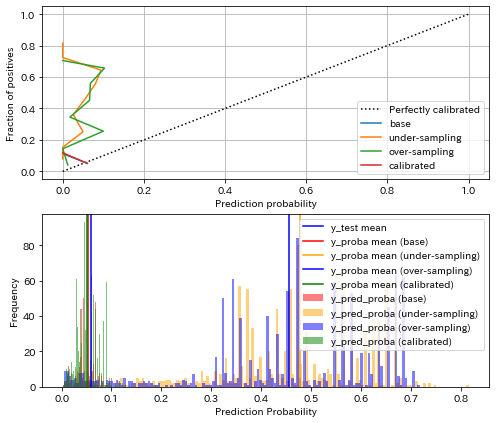

In [846]:
check_classification(df_new)

[I 2020-12-08 19:39:57,211] A new study created in memory with name: no-name-27c00b7d-15f3-4c14-8805-1b97fa408d19
feature_fraction, val_score: 0.172305:  14%|#4        | 1/7 [00:00<00:00,  7.60it/s]

重傷者の数の出力 0    5465
1     312
Name: ステータス, dtype: int64
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.205329
[20]	valid_0's binary_logloss: 0.199837
[30]	valid_0's binary_logloss: 0.195468
[40]	valid_0's binary_logloss: 0.192315
[50]	valid_0's binary_logloss: 0.189841
[60]	valid_0's binary_logloss: 0.188151
[70]	valid_0's binary_logloss: 0.185854
[80]	valid_0's binary_logloss: 0.18271
[90]	valid_0's binary_logloss: 0.181162
[100]	valid_0's binary_logloss: 0.178864
[110]	valid_0's binary_logloss: 0.177184
[120]	valid_0's binary_logloss: 0.176536
[130]	valid_0's binary_logloss: 0.174996
[140]	valid_0's binary_logloss: 0.173979
[150]	valid_0's binary_logloss: 0.173273
[160]	valid_0's binary_logloss: 0.172393
[170]	valid_0's binary_logloss: 0.172559
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.172305


feature_fraction, val_score: 0.169711:  43%|####2     | 3/7 [00:00<00:00,  7.59it/s][I 2020-12-08 19:39:57,617] Trial 2 finished with value: 0.1699416888869998 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.1697109575514956.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.203082
[20]	valid_0's binary_logloss: 0.196807
[30]	valid_0's binary_logloss: 0.193137
[40]	valid_0's binary_logloss: 0.189168
[50]	valid_0's binary_logloss: 0.185251
[60]	valid_0's binary_logloss: 0.182715
[70]	valid_0's binary_logloss: 0.180025
[80]	valid_0's binary_logloss: 0.177797
[90]	valid_0's binary_logloss: 0.176245
[100]	valid_0's binary_logloss: 0.174583
[110]	valid_0's binary_logloss: 0.172796
[120]	valid_0's binary_logloss: 0.171888
[130]	valid_0's binary_logloss: 0.170591
[140]	valid_0's binary_logloss: 0.169858
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.169711
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.202828
[20]	valid_0's binary_logloss: 0.196523
[30]	valid_0's binary_logloss: 0.192331
[40]	valid_0's binary_logloss: 0.187875
[50]	valid_0's binary_logloss: 0.185249
[60]	valid_0's binary_logloss: 0.18

feature_fraction, val_score: 0.169711:  57%|#####7    | 4/7 [00:00<00:00,  7.44it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.203788
[20]	valid_0's binary_logloss: 0.197918
[30]	valid_0's binary_logloss: 0.193205
[40]	valid_0's binary_logloss: 0.190317
[50]	valid_0's binary_logloss: 0.186723
[60]	valid_0's binary_logloss: 0.184553
[70]	valid_0's binary_logloss: 0.182522
[80]	valid_0's binary_logloss: 0.180121
[90]	valid_0's binary_logloss: 0.178636
[100]	valid_0's binary_logloss: 0.17644
[110]	valid_0's binary_logloss: 0.175091
[120]	valid_0's binary_logloss: 0.174579
[130]	valid_0's binary_logloss: 0.173183
[140]	valid_0's binary_logloss: 0.171871
[150]	valid_0's binary_logloss: 0.171264
[160]	valid_0's binary_logloss: 0.170541
[170]	valid_0's binary_logloss: 0.170618
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.170438
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.20594
[20]	valid_0's binary_logloss: 0.200822
[30]	valid_0's binary_logloss: 0.1

feature_fraction, val_score: 0.166916:  71%|#######1  | 5/7 [00:00<00:00,  6.33it/s]

[170]	valid_0's binary_logloss: 0.174443
[180]	valid_0's binary_logloss: 0.173634
[190]	valid_0's binary_logloss: 0.172468
[200]	valid_0's binary_logloss: 0.172552
[210]	valid_0's binary_logloss: 0.17176
[220]	valid_0's binary_logloss: 0.171683
[230]	valid_0's binary_logloss: 0.171408
[240]	valid_0's binary_logloss: 0.170846
[250]	valid_0's binary_logloss: 0.17064
[260]	valid_0's binary_logloss: 0.169791
[270]	valid_0's binary_logloss: 0.16943
[280]	valid_0's binary_logloss: 0.169116
[290]	valid_0's binary_logloss: 0.168925
[300]	valid_0's binary_logloss: 0.168363
[310]	valid_0's binary_logloss: 0.167909
[320]	valid_0's binary_logloss: 0.167484
[330]	valid_0's binary_logloss: 0.167272
[340]	valid_0's binary_logloss: 0.167232
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.166916
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.203012
[20]	valid_0's binary_logloss: 0.197114
[30]	valid_0's binary_logloss: 0.192677
[40]	va

num_leaves, val_score: 0.166916:   0%|          | 0/20 [00:00<?, ?it/s]

[160]	valid_0's binary_logloss: 0.170346
[170]	valid_0's binary_logloss: 0.170214
[180]	valid_0's binary_logloss: 0.169911
[190]	valid_0's binary_logloss: 0.169102
[200]	valid_0's binary_logloss: 0.168555
[210]	valid_0's binary_logloss: 0.167785
[220]	valid_0's binary_logloss: 0.167093
[230]	valid_0's binary_logloss: 0.167365
Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.167093
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.202828
[20]	valid_0's binary_logloss: 0.196523
[30]	valid_0's binary_logloss: 0.192331
[40]	valid_0's binary_logloss: 0.188746
[50]	valid_0's binary_logloss: 0.185391
[60]	valid_0's binary_logloss: 0.182639
[70]	valid_0's binary_logloss: 0.180137
[80]	valid_0's binary_logloss: 0.178173
[90]	valid_0's binary_logloss: 0.176418
[100]	valid_0's binary_logloss: 0.174723
[110]	valid_0's binary_logloss: 0.173525
[120]	valid_0's binary_logloss: 0.172124
[130]	valid_0's binary_logloss: 0.170585
[140]	vali

num_leaves, val_score: 0.163593:  10%|#         | 2/20 [00:00<00:02,  7.89it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.198527
[20]	valid_0's binary_logloss: 0.188192
[30]	valid_0's binary_logloss: 0.183622
[40]	valid_0's binary_logloss: 0.180729
[50]	valid_0's binary_logloss: 0.177754
[60]	valid_0's binary_logloss: 0.175608
[70]	valid_0's binary_logloss: 0.172638
[80]	valid_0's binary_logloss: 0.170545
[90]	valid_0's binary_logloss: 0.169718
[100]	valid_0's binary_logloss: 0.168596
[110]	valid_0's binary_logloss: 0.167867
[120]	valid_0's binary_logloss: 0.167191
[130]	valid_0's binary_logloss: 0.166458
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.166296
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164

num_leaves, val_score: 0.163593:  20%|##        | 4/20 [00:00<00:02,  7.68it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


[I 2020-12-08 19:39:58,810] Trial 10 finished with value: 0.16359297252493088 and parameters: {'num_leaves': 256}. Best is trial 8 with value: 0.16359297252493088.
num_leaves, val_score: 0.163593:  25%|##5       | 5/20 [00:00<00:01,  7.53it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966


num_leaves, val_score: 0.163593:  35%|###5      | 7/20 [00:00<00:01,  7.06it/s]

[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


num_leaves, val_score: 0.163593:  45%|####5     | 9/20 [00:01<00:01,  7.15it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


[I 2020-12-08 19:39:59,528] Trial 15 finished with value: 0.16359297252493088 and parameters: {'num_leaves': 68}. Best is trial 8 with value: 0.16359297252493088.
num_leaves, val_score: 0.163593:  50%|#####     | 10/20 [00:01<00:01,  7.30it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195416
[20]	valid_0's binary_logloss: 0.181268
[30]	valid_0's binary_logloss: 0.176117
[40]	valid_0's binary_logloss: 0.172423
[50]	valid_0's binary_logloss: 0.169139
[60]	valid_0's binary_logloss: 0.167214
[70]	valid_0's binary_logloss: 0.165067
[80]	valid_0's binary_logloss: 0.163575
[90]	valid_0's binary_logloss: 0.163582
[100]	valid_0's binary_logloss: 0.163531
[110]	valid_0's binary_logloss: 0.163081


num_leaves, val_score: 0.162127:  60%|######    | 12/20 [00:01<00:01,  7.25it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.197471
[20]	valid_0's binary_logloss: 0.18495
[30]	valid_0's binary_logloss: 0.17992
[40]	valid_0's binary_logloss: 0.176695
[50]	valid_0's binary_logloss: 0.173477
[60]	valid_0's binary_logloss: 0.171257
[70]	valid_0's binary_logloss: 0.168449
[80]	valid_0's binary_logloss: 0.167306
[90]	valid_0's binary_logloss: 0.166626
[100]	valid_0's binary_logloss: 0.166034
[110]	valid_0's binary_logloss: 0.165449
[120]	valid_0's binary_logloss: 0.165074
[130]	valid_0's binary_logloss: 0.164466
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.164402
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.16485

num_leaves, val_score: 0.162127:  70%|#######   | 14/20 [00:01<00:00,  7.35it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388


num_leaves, val_score: 0.162127:  80%|########  | 16/20 [00:02<00:00,  7.08it/s]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163601
[90]	valid_0's binary_logloss: 0.163881
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


num_leaves, val_score: 0.162127:  90%|######### | 18/20 [00:02<00:00,  7.21it/s][I 2020-12-08 19:40:00,775] Trial 24 finished with value: 0.16359297252493088 and parameters: {'num_leaves': 134}. Best is trial 17 with value: 0.16212703594420885.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


num_leaves, val_score: 0.162127:  95%|#########5| 19/20 [00:02<00:00,  7.34it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195385
[20]	valid_0's binary_logloss: 0.181181
[30]	valid_0's binary_logloss: 0.175991
[40]	valid_0's binary_logloss: 0.172163
[50]	valid_0's binary_logloss: 0.168994
[60]	valid_0's binary_logloss: 0.166966
[70]	valid_0's binary_logloss: 0.164853
[80]	valid_0's binary_logloss: 0.163604
[90]	valid_0's binary_logloss: 0.16388
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.163593


bagging, val_score: 0.162127:  10%|#         | 1/10 [00:00<00:01,  7.90it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.197085
[20]	valid_0's binary_logloss: 0.182083
[30]	valid_0's binary_logloss: 0.176965
[40]	valid_0's binary_logloss: 0.173789
[50]	valid_0's binary_logloss: 0.171268
[60]	valid_0's binary_logloss: 0.168917
[70]	valid_0's binary_logloss: 0.166513
[80]	valid_0's binary_logloss: 0.164941
[90]	valid_0's binary_logloss: 0.164958
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.164849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194441
[20]	valid_0's binary_logloss: 0.178454
[30]	valid_0's binary_logloss: 0.17392
[40]	valid_0's binary_logloss: 0.170029
[50]	valid_0's binary_logloss: 0.167586
[60]	valid_0's binary_logloss: 0.165542
[70]	valid_0's binary_logloss: 0.163619
[80]	valid_0's binary_logloss: 0.162687
[90]	valid_0's binary_logloss: 0.162585
[100]	valid_0's binary_logloss: 0.16217
[110]	valid_0's binary_logloss: 0.161751
[

bagging, val_score: 0.160373:  30%|###       | 3/10 [00:00<00:01,  6.91it/s]

[140]	valid_0's binary_logloss: 0.161276
[150]	valid_0's binary_logloss: 0.161089
[160]	valid_0's binary_logloss: 0.160792
[170]	valid_0's binary_logloss: 0.1607
[180]	valid_0's binary_logloss: 0.160524
[190]	valid_0's binary_logloss: 0.16041
[200]	valid_0's binary_logloss: 0.160447
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.160373
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194507
[20]	valid_0's binary_logloss: 0.178642
[30]	valid_0's binary_logloss: 0.174029
[40]	valid_0's binary_logloss: 0.170031
[50]	valid_0's binary_logloss: 0.167562
[60]	valid_0's binary_logloss: 0.165424
[70]	valid_0's binary_logloss: 0.16359
[80]	valid_0's binary_logloss: 0.16303
[90]	valid_0's binary_logloss: 0.162613
[100]	valid_0's binary_logloss: 0.162093
[110]	valid_0's binary_logloss: 0.161876
[120]	valid_0's binary_logloss: 0.161642
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.161621


bagging, val_score: 0.160373:  40%|####      | 4/10 [00:00<00:00,  6.79it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194502
[20]	valid_0's binary_logloss: 0.17862
[30]	valid_0's binary_logloss: 0.173966
[40]	valid_0's binary_logloss: 0.169945
[50]	valid_0's binary_logloss: 0.167464
[60]	valid_0's binary_logloss: 0.165605
[70]	valid_0's binary_logloss: 0.163809
[80]	valid_0's binary_logloss: 0.162834
[90]	valid_0's binary_logloss: 0.162444
[100]	valid_0's binary_logloss: 0.161971
[110]	valid_0's binary_logloss: 0.161629
[120]	valid_0's binary_logloss: 0.161147
[130]	valid_0's binary_logloss: 0.160881
[140]	valid_0's binary_logloss: 0.160917
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.160842
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194916
[20]	valid_0's binary_logloss: 0.178966
[30]	valid_0's binary_logloss: 0.174305
[40]	valid_0's binary_logloss: 0.170064
[50]	valid_0's binary_logloss: 0.167518
[60]	valid_0's binary_logloss: 0.165

bagging, val_score: 0.160373:  60%|######    | 6/10 [00:00<00:00,  6.38it/s]

[90]	valid_0's binary_logloss: 0.162765
[100]	valid_0's binary_logloss: 0.162079
[110]	valid_0's binary_logloss: 0.161632
[120]	valid_0's binary_logloss: 0.161129
[130]	valid_0's binary_logloss: 0.161195
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.161129
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194505
[20]	valid_0's binary_logloss: 0.178619
[30]	valid_0's binary_logloss: 0.17398
[40]	valid_0's binary_logloss: 0.169958
[50]	valid_0's binary_logloss: 0.167481
[60]	valid_0's binary_logloss: 0.165587
[70]	valid_0's binary_logloss: 0.163774
[80]	valid_0's binary_logloss: 0.162864
[90]	valid_0's binary_logloss: 0.162626
[100]	valid_0's binary_logloss: 0.162159
[110]	valid_0's binary_logloss: 0.161786
[120]	valid_0's binary_logloss: 0.161388
[130]	valid_0's binary_logloss: 0.161241
[140]	valid_0's binary_logloss: 0.161261
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.161205


[I 2020-12-08 19:40:02,008] Trial 32 finished with value: 0.16120503701536534 and parameters: {'bagging_fraction': 0.9957220120702848, 'bagging_freq': 1}. Best is trial 28 with value: 0.16037338716894317.
bagging, val_score: 0.160373:  70%|#######   | 7/10 [00:01<00:00,  6.49it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194503
[20]	valid_0's binary_logloss: 0.178638
[30]	valid_0's binary_logloss: 0.174027
[40]	valid_0's binary_logloss: 0.170097
[50]	valid_0's binary_logloss: 0.167525
[60]	valid_0's binary_logloss: 0.165463
[70]	valid_0's binary_logloss: 0.163601
[80]	valid_0's binary_logloss: 0.163034
[90]	valid_0's binary_logloss: 0.162425
[100]	valid_0's binary_logloss: 0.161946
[110]	valid_0's binary_logloss: 0.161655
[120]	valid_0's binary_logloss: 0.161397
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.161365
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194502
[20]	valid_0's binary_logloss: 0.17862
[30]	valid_0's binary_logloss: 0.173966
[40]	valid_0's binary_logloss: 0.169945
[50]	valid_0's binary_logloss: 0.167464
[60]	valid_0's binary_logloss: 0.165605
[70]	valid_0's binary_logloss: 0.163809
[80]	valid_0's binary_logloss: 0.16283

bagging, val_score: 0.160373:  90%|######### | 9/10 [00:01<00:00,  6.48it/s]

[100]	valid_0's binary_logloss: 0.161971
[110]	valid_0's binary_logloss: 0.161629
[120]	valid_0's binary_logloss: 0.161147
[130]	valid_0's binary_logloss: 0.160881
[140]	valid_0's binary_logloss: 0.160917
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.160842
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194503
[20]	valid_0's binary_logloss: 0.178638
[30]	valid_0's binary_logloss: 0.174027
[40]	valid_0's binary_logloss: 0.170097
[50]	valid_0's binary_logloss: 0.167525
[60]	valid_0's binary_logloss: 0.165463
[70]	valid_0's binary_logloss: 0.163601
[80]	valid_0's binary_logloss: 0.163034
[90]	valid_0's binary_logloss: 0.162425
[100]	valid_0's binary_logloss: 0.161946
[110]	valid_0's binary_logloss: 0.161655
[120]	valid_0's binary_logloss: 0.161397
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.161365


feature_fraction_stage2, val_score: 0.160373:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.195516
[20]	valid_0's binary_logloss: 0.179659
[30]	valid_0's binary_logloss: 0.174948
[40]	valid_0's binary_logloss: 0.170612
[50]	valid_0's binary_logloss: 0.168116
[60]	valid_0's binary_logloss: 0.166177
[70]	valid_0's binary_logloss: 0.164705
[80]	valid_0's binary_logloss: 0.163616
[90]	valid_0's binary_logloss: 0.1634
[100]	valid_0's binary_logloss: 0.163205
[110]	valid_0's binary_logloss: 0.163051
[120]	valid_0's binary_logloss: 0.162295
[130]	valid_0's binary_logloss: 0.162287
[140]	valid_0's binary_logloss: 0.163082
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.162225
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.186191
[20]	valid_0's binary_logloss: 0.173695
[30]	valid_0's binary_logloss: 0.16857
[40]	valid_0's binary_logloss: 0.166832
[50]	valid_0's binary_logloss: 0.165942


feature_fraction_stage2, val_score: 0.160373:  67%|######6   | 2/3 [00:00<00:00,  7.27it/s]

[60]	valid_0's binary_logloss: 0.164884
[70]	valid_0's binary_logloss: 0.16359
[80]	valid_0's binary_logloss: 0.162338
[90]	valid_0's binary_logloss: 0.162154
[100]	valid_0's binary_logloss: 0.16214
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.161949
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.18853
[20]	valid_0's binary_logloss: 0.175324
[30]	valid_0's binary_logloss: 0.169749
[40]	valid_0's binary_logloss: 0.167876
[50]	valid_0's binary_logloss: 0.166584
[60]	valid_0's binary_logloss: 0.165153
[70]	valid_0's binary_logloss: 0.163906
[80]	valid_0's binary_logloss: 0.163081
[90]	valid_0's binary_logloss: 0.162259
[100]	valid_0's binary_logloss: 0.161922
[110]	valid_0's binary_logloss: 0.161741
[120]	valid_0's binary_logloss: 0.161319
[130]	valid_0's binary_logloss: 0.161452
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.161177


regularization_factors, val_score: 0.160373:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.18853
[20]	valid_0's binary_logloss: 0.175324
[30]	valid_0's binary_logloss: 0.169749
[40]	valid_0's binary_logloss: 0.167876
[50]	valid_0's binary_logloss: 0.166584
[60]	valid_0's binary_logloss: 0.165153
[70]	valid_0's binary_logloss: 0.163906
[80]	valid_0's binary_logloss: 0.163081
[90]	valid_0's binary_logloss: 0.162259
[100]	valid_0's binary_logloss: 0.161922
[110]	valid_0's binary_logloss: 0.161741
[120]	valid_0's binary_logloss: 0.161319
[130]	valid_0's binary_logloss: 0.161452
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.161177
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191165
[20]	valid_0's binary_logloss: 0.174459
[30]	valid_0's binary_logloss: 0.17039
[40]	valid_0's binary_logloss: 0.166713
[50]	valid_0's binary_logloss: 0.164377


regularization_factors, val_score: 0.160182:  10%|#         | 2/20 [00:00<00:02,  7.17it/s]

[60]	valid_0's binary_logloss: 0.162694
[70]	valid_0's binary_logloss: 0.161151
[80]	valid_0's binary_logloss: 0.160961
[90]	valid_0's binary_logloss: 0.160879
[100]	valid_0's binary_logloss: 0.160557
[110]	valid_0's binary_logloss: 0.16028
[120]	valid_0's binary_logloss: 0.160405
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.160182
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191263
[20]	valid_0's binary_logloss: 0.174447
[30]	valid_0's binary_logloss: 0.170292
[40]	valid_0's binary_logloss: 0.166741
[50]	valid_0's binary_logloss: 0.16416
[60]	valid_0's binary_logloss: 0.16268
[70]	valid_0's binary_logloss: 0.160993
[80]	valid_0's binary_logloss: 0.160849
[90]	valid_0's binary_logloss: 0.161006
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.160849


regularization_factors, val_score: 0.159901:  15%|#5        | 3/20 [00:00<00:02,  6.92it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[90]	valid_0's binary_logloss: 0.160576
[100]	valid_0's binary_logloss: 0.16047
[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191165
[20]	valid_0's binary_logloss: 0.174462
[30]	valid_0's binary_logloss: 0.170395
[40]	valid_0's binary_logloss: 0.166733
[50]	valid_0's binary_logloss: 0.164318
[60]	valid_0's binary_logloss: 0.162718
[70]	valid_0's binary_logloss: 0.161235
[80]	valid_0's binary_logloss: 0.161119


regularization_factors, val_score: 0.159901:  25%|##5       | 5/20 [00:00<00:02,  7.40it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.190969
[20]	valid_0's binary_logloss: 0.174254
[30]	valid_0's binary_logloss: 0.170301
[40]	valid_0's binary_logloss: 0.166784
[50]	valid_0's binary_logloss: 0.164285
[60]	valid_0's binary_logloss: 0.162503
[70]	valid_0's binary_logloss: 0.16114
[80]	valid_0's binary_logloss: 0.161208
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.161102
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.194548
[20]	valid_0's binary_logloss: 0.178569
[30]	valid_0's binary_logloss: 0.17439
[40]	valid_0's binary_logloss: 0.170512
[50]	valid_0's binary_logloss: 0.168168
[60]	valid_0's binary_logloss: 0.166329
[70]	valid_0's binary_logloss: 0.164911
[80]	valid_0's binary_logloss: 0.164199
[90]	valid_0's binary_logloss: 0.163654
[100]	valid_0's binary_logloss: 0.163399
[110]	valid_0's binary_logloss: 0.16308
[120]	valid_0's binary_logloss: 0.162806
[

regularization_factors, val_score: 0.159901:  35%|###5      | 7/20 [00:01<00:01,  6.78it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.196139
[20]	valid_0's binary_logloss: 0.180831
[30]	valid_0's binary_logloss: 0.176203
[40]	valid_0's binary_logloss: 0.171845
[50]	valid_0's binary_logloss: 0.169319
[60]	valid_0's binary_logloss: 0.167139
[70]	valid_0's binary_logloss: 0.165051
[80]	valid_0's binary_logloss: 0.163823
[90]	valid_0's binary_logloss: 0.16323
[100]	valid_0's binary_logloss: 0.162906
[110]	valid_0's binary_logloss: 0.162503
[120]	valid_0's binary_logloss: 0.162095
[130]	valid_0's binary_logloss: 0.161793
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.161749
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.190988
[20]	valid_0's binary_logloss: 0.174937
[30]	valid_0's binary_logloss: 0.17088
[40]	valid_0's binary_logloss: 0.166989
[50]	valid_0's binary_logloss: 0.16448
[60]	valid_0's binary_logloss: 0.162863


regularization_factors, val_score: 0.159901:  45%|####5     | 9/20 [00:01<00:01,  6.51it/s][I 2020-12-08 19:40:04,422] Trial 48 finished with value: 0.1709593168479181 and parameters: {'lambda_l1': 8.668623911908522, 'lambda_l2': 2.0356658881008927}. Best is trial 42 with value: 0.1599008114769749.


[70]	valid_0's binary_logloss: 0.161248
[80]	valid_0's binary_logloss: 0.161157
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.161096
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.198507
[20]	valid_0's binary_logloss: 0.185374
[30]	valid_0's binary_logloss: 0.181959
[40]	valid_0's binary_logloss: 0.178395
[50]	valid_0's binary_logloss: 0.176237
[60]	valid_0's binary_logloss: 0.17478
[70]	valid_0's binary_logloss: 0.17334
[80]	valid_0's binary_logloss: 0.172444
[90]	valid_0's binary_logloss: 0.172101
[100]	valid_0's binary_logloss: 0.171752
[110]	valid_0's binary_logloss: 0.17153
[120]	valid_0's binary_logloss: 0.171242
[130]	valid_0's binary_logloss: 0.171214
[140]	valid_0's binary_logloss: 0.171199
[150]	valid_0's binary_logloss: 0.171098
[160]	valid_0's binary_logloss: 0.171069
[170]	valid_0's binary_logloss: 0.171046
[180]	valid_0's binary_logloss: 0.171025
[190]	valid_0's binary_logloss: 0.170959
[200]	valid_0's 

regularization_factors, val_score: 0.159901:  55%|#####5    | 11/20 [00:01<00:01,  7.16it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191142
[20]	valid_0's binary_logloss: 0.174437
[30]	valid_0's binary_logloss: 0.170357
[40]	valid_0's binary_logloss: 0.166694
[50]	valid_0's binary_logloss: 0.164241
[60]	valid_0's binary_logloss: 0.162663
[70]	valid_0's binary_logloss: 0.161343
[80]	valid_0's binary_logloss: 0.16124
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.16105
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.190991
[20]	valid_0's binary_logloss: 0.174941
[30]	valid_0's binary_logloss: 0.170885
[40]	valid_0's binary_logloss: 0.166999
[50]	valid_0's binary_logloss: 0.16449
[60]	valid_0's binary_logloss: 0.162828
[70]	valid_0's binary_logloss: 0.161224
[80]	valid_0's binary_logloss: 0.161084
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.161073


regularization_factors, val_score: 0.159901:  65%|######5   | 13/20 [00:01<00:00,  7.66it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.192017
[20]	valid_0's binary_logloss: 0.175987
[30]	valid_0's binary_logloss: 0.171722
[40]	valid_0's binary_logloss: 0.16756
[50]	valid_0's binary_logloss: 0.165222
[60]	valid_0's binary_logloss: 0.163554
[70]	valid_0's binary_logloss: 0.161938
[80]	valid_0's binary_logloss: 0.161508
[90]	valid_0's binary_logloss: 0.16175
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.161508
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191556
[20]	valid_0's binary_logloss: 0.174709
[30]	valid_0's binary_logloss: 0.17053
[40]	valid_0's binary_logloss: 0.166838
[50]	valid_0's binary_logloss: 0.164741
[60]	valid_0's binary_logloss: 0.162934
[70]	valid_0's binary_logloss: 0.161378
[80]	valid_0's binary_logloss: 0.161323
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.16117


regularization_factors, val_score: 0.159901:  70%|#######   | 14/20 [00:02<00:00,  6.65it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.19374
[20]	valid_0's binary_logloss: 0.177749
[30]	valid_0's binary_logloss: 0.173445
[40]	valid_0's binary_logloss: 0.169412
[50]	valid_0's binary_logloss: 0.167022
[60]	valid_0's binary_logloss: 0.165354
[70]	valid_0's binary_logloss: 0.163536
[80]	valid_0's binary_logloss: 0.162553
[90]	valid_0's binary_logloss: 0.162099
[100]	valid_0's binary_logloss: 0.161754
[110]	valid_0's binary_logloss: 0.161482
[120]	valid_0's binary_logloss: 0.161236
[130]	valid_0's binary_logloss: 0.161087
[140]	valid_0's binary_logloss: 0.161035
[150]	valid_0's binary_logloss: 0.160714
[160]	valid_0's binary_logloss: 0.160587
[170]	valid_0's binary_logloss: 0.160508
[180]	valid_0's binary_logloss: 0.160412
[190]	valid_0's binary_logloss: 0.160354
[200]	valid_0's binary_logloss: 0.1604
[210]	valid_0's binary_logloss: 0.16026
[220]	valid_0's binary_logloss: 0.160308
Early stopping, best iteration is:
[211]	valid_0'

regularization_factors, val_score: 0.159901:  75%|#######5  | 15/20 [00:02<00:00,  6.18it/s]

[10]	valid_0's binary_logloss: 0.193552
[20]	valid_0's binary_logloss: 0.177665
[30]	valid_0's binary_logloss: 0.173384
[40]	valid_0's binary_logloss: 0.169334
[50]	valid_0's binary_logloss: 0.166995
[60]	valid_0's binary_logloss: 0.16522
[70]	valid_0's binary_logloss: 0.163443
[80]	valid_0's binary_logloss: 0.162584
[90]	valid_0's binary_logloss: 0.162364
[100]	valid_0's binary_logloss: 0.162097
[110]	valid_0's binary_logloss: 0.161828
[120]	valid_0's binary_logloss: 0.161482
[130]	valid_0's binary_logloss: 0.161342
[140]	valid_0's binary_logloss: 0.161312
[150]	valid_0's binary_logloss: 0.160995
[160]	valid_0's binary_logloss: 0.160825
[170]	valid_0's binary_logloss: 0.160786
[180]	valid_0's binary_logloss: 0.160673
[190]	valid_0's binary_logloss: 0.160631
[200]	valid_0's binary_logloss: 0.160679
[210]	valid_0's binary_logloss: 0.160539
[220]	valid_0's binary_logloss: 0.160604
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.160538
Training until validation scores

regularization_factors, val_score: 0.159901:  85%|########5 | 17/20 [00:02<00:00,  6.80it/s]

[50]	valid_0's binary_logloss: 0.166861
[60]	valid_0's binary_logloss: 0.165021
[70]	valid_0's binary_logloss: 0.163163
[80]	valid_0's binary_logloss: 0.162305
[90]	valid_0's binary_logloss: 0.162181
[100]	valid_0's binary_logloss: 0.161937
[110]	valid_0's binary_logloss: 0.161648
[120]	valid_0's binary_logloss: 0.161288
[130]	valid_0's binary_logloss: 0.161293
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.161283
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191849
[20]	valid_0's binary_logloss: 0.175244
[30]	valid_0's binary_logloss: 0.171006
[40]	valid_0's binary_logloss: 0.16715
[50]	valid_0's binary_logloss: 0.164775
[60]	valid_0's binary_logloss: 0.16323
[70]	valid_0's binary_logloss: 0.161846
[80]	valid_0's binary_logloss: 0.161647
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.161502


regularization_factors, val_score: 0.159901:  90%|######### | 18/20 [00:02<00:00,  7.24it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191751
[20]	valid_0's binary_logloss: 0.175057
[30]	valid_0's binary_logloss: 0.17098
[40]	valid_0's binary_logloss: 0.16694
[50]	valid_0's binary_logloss: 0.16462
[60]	valid_0's binary_logloss: 0.163202
[70]	valid_0's binary_logloss: 0.16149
[80]	valid_0's binary_logloss: 0.161271
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.161169
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.198719
[20]	valid_0's binary_logloss: 0.185286
[30]	valid_0's binary_logloss: 0.181826
[40]	valid_0's binary_logloss: 0.178592
[50]	valid_0's binary_logloss: 0.176634
[60]	valid_0's binary_logloss: 0.175284
[70]	valid_0's binary_logloss: 0.174105
[80]	valid_0's binary_logloss: 0.173369
[90]	valid_0's binary_logloss: 0.172867
[100]	valid_0's binary_logloss: 0.172448
[110]	valid_0's binary_logloss: 0.172351
[120]	valid_0's binary_logloss: 0.172227
[1

min_data_in_leaf, val_score: 0.159901:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191301
[20]	valid_0's binary_logloss: 0.174845
[30]	valid_0's binary_logloss: 0.170687
[40]	valid_0's binary_logloss: 0.167115
[50]	valid_0's binary_logloss: 0.164922
[60]	valid_0's binary_logloss: 0.16322
[70]	valid_0's binary_logloss: 0.161728
[80]	valid_0's binary_logloss: 0.161615
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.161539
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[90]	valid_0's binary_logloss: 0.160576


min_data_in_leaf, val_score: 0.159901:  40%|####      | 2/5 [00:00<00:00,  6.57it/s]

[100]	valid_0's binary_logloss: 0.16047
[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[90]	valid_0's binary_logloss: 0.160576
[100]	valid_0's binary_logloss: 0.16047
[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901


min_data_in_leaf, val_score: 0.159901:  60%|######    | 3/5 [00:00<00:00,  6.57it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[90]	valid_0's binary_logloss: 0.160576
[100]	valid_0's binary_logloss: 0.16047
[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[9

min_data_in_leaf, val_score: 0.159901: 100%|##########| 5/5 [00:00<00:00,  6.55it/s]

[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.191242
[20]	valid_0's binary_logloss: 0.174426
[30]	valid_0's binary_logloss: 0.170472
[40]	valid_0's binary_logloss: 0.16677
[50]	valid_0's binary_logloss: 0.164073
[60]	valid_0's binary_logloss: 0.162509
[70]	valid_0's binary_logloss: 0.16106
[80]	valid_0's binary_logloss: 0.160851
[90]	valid_0's binary_logloss: 0.160576
[100]	valid_0's binary_logloss: 0.16047
[110]	valid_0's binary_logloss: 0.160157
[120]	valid_0's binary_logloss: 0.159965
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.159901
recallが 0.1 の割合で指定された時のprecision 0.3684210526315789



Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


recallが 0.2 の割合で指定された時のprecision 0.391304347826087
recallが 0.3 の割合で指定された時のprecision 0.3559322033898305
recallが 0.4 の割合で指定された時のprecision 0.3146067415730337
recallが 0.5 の割合で指定された時のprecision 0.3148148148148148
recallが 0.6 の割合で指定された時のprecision 0.271523178807947
recallが 0.7 の割合で指定された時のprecision 0.20425531914893616
recallが 0.8 の割合で指定された時のprecision 0.18394648829431437
recallが 0.9 の割合で指定された時のprecision 0.14123006833712984
[10]	cv_agg's binary_logloss: 0.660969 + 0.00557242
[20]	cv_agg's binary_logloss: 0.641969 + 0.00852008
[30]	cv_agg's binary_logloss: 0.62343 + 0.00959326
[40]	cv_agg's binary_logloss: 0.611141 + 0.00886448
[50]	cv_agg's binary_logloss: 0.600085 + 0.01071
[60]	cv_agg's binary_logloss: 0.591905 + 0.0127181
[70]	cv_agg's binary_logloss: 0.580484 + 0.0120452
[80]	cv_agg's binary_logloss: 0.576695 + 0.0133932
[90]	cv_agg's binary_logloss: 0.571505 + 0.0157533
[100]	cv_agg's binary_logloss: 0.566997 + 0.0164985
[110]	cv_agg's binary_logloss: 0.563723 + 0.0170266
[120]	cv_agg's bina

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documenta

lightgbm base roc auc 0.8445395517512633
lightgbm us roc auc 0.7532165380051463
logi base roc auc 0.6505073130408117
logi us roc auc 0.6412810154260496


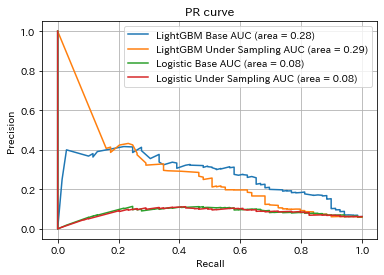

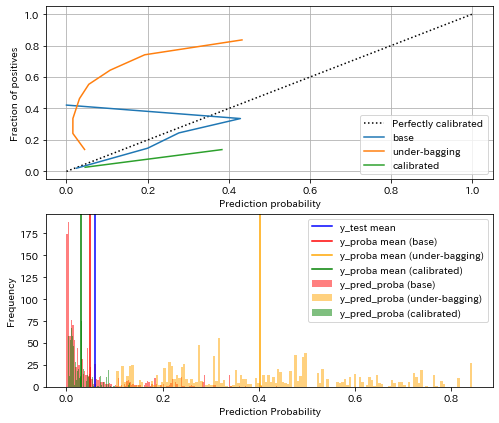

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


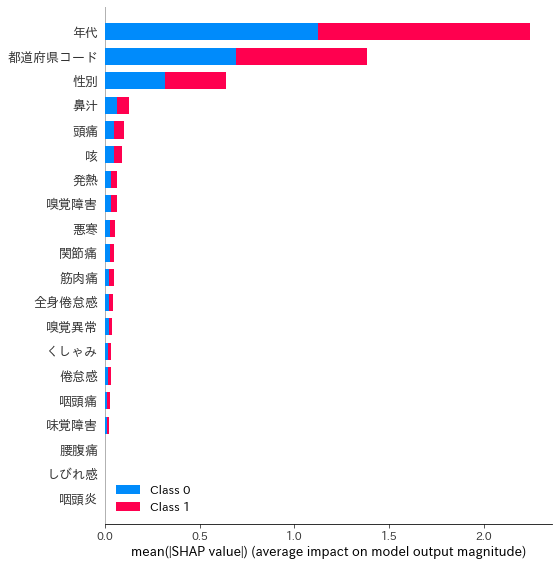

In [847]:
class UnderBaggingKFold(BaseCrossValidator):
    '''CV に使うだけで UnderBagging できるKFold実装(少ないクラスのデータは各 Fold で重複して選択される)'''

    def __init__(self, n_splits=5, shuffle=True, random_states=None, test_size=0.2, whole_testing=False):
        '''
        :param n_splits: Fold の分割数
        :param shuffle: 分割時にデータをシャッフルするか
        :param random_states: 各 Fold の乱数シード
        :param test_size: Under-sampling された中でテスト用データとして使う割合
        :param whole_testing: Under-sampling で選ばれなかった全てのデータをテスト用データに追加するか
        '''
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_states = random_states
        self.test_size = test_size
        self.whole_testing = whole_testing

        self.sample_indices_ = []

        if random_states is not None:
            # 各 Fold の乱数シードが指定されているなら分割数をそれに合わせる
            self.n_splits = len(random_states)
        else:
            # 乱数シードが指定されていないときは分割数だけ None で埋めておく
            self.random_states = [None] * self.n_splits

        # 分割数だけ Under-sampling 用のインスタンスを作っておく
        self.samplers_ = [
            RandomUnderSampler(random_state=random_state)
            for random_state in self.random_states
        ]

    def split(self, X, y=None, groups=None):
        '''データを学習用とテスト用に分割する'''
        if X.ndim < 2:
            # RandomUnderSampler#fit_resample() は X が 1d-array だと文句を言う
            X = np.vstack(X)

        for i in range(self.n_splits):
            # データを Under-sampling して均衡データにする
            sampler = self.samplers_[i]
            _, y_sampled = sampler.fit_resample(X, y)
            # 選ばれたデータのインデックスを取り出す
            sampled_indices = sampler.sample_indices_

            # 選ばれたデータのインデックスを記録しておく
            self.sample_indices_ = sampled_indices

            # 選ばれたデータを学習用とテスト用に分割する
            split_data = train_test_split(sampled_indices, shuffle=self.shuffle, test_size=self.test_size, stratify=y_sampled, random_state=self.random_states[i],)
            train_indices, test_indices = split_data

            if self.whole_testing:
                # Under-sampling で選ばれなかったデータをテスト用に追加する
                mask = np.ones(len(X), dtype=np.bool)
                mask[sampled_indices] = False
                X_indices = np.arange(len(X))
                non_sampled_indices = X_indices[mask]
                test_indices = np.concatenate([test_indices, non_sampled_indices])

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


class ModelExtractionCallback(object):
    # lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

def main():
  df = df_new
  # df.columns = list(range(len(df.columns)))
  X = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  X = df.drop([""], axis=1).drop('ステータス', axis=1)
  y = df['ステータス']
  border_value = 0.2

  # 概要の出力
  print("重傷者の数の出力", df['ステータス'].value_counts())

  # 学習用データと検証用データに分割する (Hold-out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # まずは不均衡データのまま学習させる
  lgb_params = {
      'bagging_fraction': 0.5656094985179433,
      'bagging_freq': 1,
      'feature_fraction': 0.4,
      'feature_pre_filter': False,
      'lambda_l1': 4.678162797519851e-06,
      'lambda_l2': 4.767625955074478,
      'metric': 'binary_logloss',
      'min_child_samples': 25,
      'num_leaves': 2,
      'objective': 'binary',
      'verbosity': -1
  }
  X_tr, X_ev, y_tr, y_ev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_ev, y_ev, reference=lgb_train)
  booster = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)

  # 検証用データを予測させる
  y_pred_proba_base = booster.predict(X_test)
  y_pred_base = np.where(y_pred_proba_base > border_value, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_base, percentage)

  # 均衡データで学習させる (UnderBagging)
  folds = UnderBaggingKFold(random_states=range(42, 42 + 5))
  lgb_train = lgb.Dataset(X_train, y_train)
  extraction_cb = ModelExtractionCallback()
  callbacks = [
      extraction_cb,
  ]
  lgb.cv(lgb_params, lgb_train,
          num_boost_round=1000,
          early_stopping_rounds=10,
          folds=folds,
          callbacks=callbacks,
          verbose_eval=10)
  cv_booster = extraction_cb.boosters_proxy
  # 検証用データを予測させる
  y_pred_proba_ub_list = cv_booster.predict(X_test)
  y_pred_proba_ub = np.array(y_pred_proba_ub_list).mean(axis=0)
  y_pred_ub = np.where(y_pred_proba_ub > border_value, 1, 0)

  # サンプリングレートを元に確率を補正する
  y_sampled = y_train.reindex(folds.sample_indices_)
  y_sampled_negative_len = np.count_nonzero(y_sampled == 0)
  beta = y_sampled_negative_len / len(y_train)
  y_pred_proba_cb = probability_calibration(y_pred_proba_ub, beta)
  y_pred_cb = np.where(y_pred_proba_cb > border_value, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_cb, percentage)

  # 各種評価指標を出力する
  print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
  print('precision (under-bagging): ', metrics.precision_score(y_test, y_pred_ub))
  print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
  print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
  print('recall (under-bagging): ', metrics.recall_score(y_test, y_pred_ub))
  print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
  print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
  print('F1 (under-bagging): ', metrics.f1_score(y_test, y_pred_ub))
  print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
  print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
  print('ROC AUC (under-bagging): ', metrics.roc_auc_score(y_test, y_pred_ub))
  print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

  # 各モデルが予測した内容の統計量
  print('y_test mean', y_test.mean())
  print('y_proba mean (base)', y_pred_proba_base.mean())
  print('y_proba mean (under-sampling)', y_pred_proba_ub.mean())
  print('y_proba mean (calibrated)', y_pred_proba_cb.mean())


  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train, y_train)
  # 検証用データを予測させる
  Y_pred_proba_base = clf.predict_proba(X_test)[:, 1]
  Y_pred_base = np.where(Y_pred_proba_base > border_value, 1, 0)

  # Under-sampling で均衡データにする
  sampler = RandomUnderSampler(random_state=42)
  X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

  # Over-sampling で均衡データにする
  over_sampler = SMOTE(random_state=42)
  X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

  # Under-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_sampled, y_train_sampled)
  # Under-samplingの検証用データを予測させる
  Y_pred_proba_us = clf.predict_proba(X_test)[:, 1]
  Y_pred_us = np.where(Y_pred_proba_us > border_value, 1, 0)

  # lightgbm base
  precision1, recall1, thresholds1 = metrics.precision_recall_curve(y_test, y_pred_proba_base)
  print("lightgbm base roc auc", metrics.roc_auc_score(y_test, y_pred_proba_base))
  auc1 = metrics.auc(recall1, precision1)

  # lightgbm undersampling
  precision2, recall2, thresholds2 = metrics.precision_recall_curve(y_test, y_pred_proba_ub)
  print("lightgbm us roc auc", metrics.roc_auc_score(y_test, y_pred_proba_ub))
  auc2 = metrics.auc(recall2, precision2)

  # logistic base
  precision3, recall3, thresholds3 = metrics.precision_recall_curve(y_test, Y_pred_proba_base)
  print("logi base roc auc", metrics.roc_auc_score(y_test, Y_pred_proba_base))
  auc3 = metrics.auc(recall3, precision3)

  # logistic undersampling
  precision4, recall4, thresholds4 = metrics.precision_recall_curve(y_test, Y_pred_proba_us)
  print("logi us roc auc", metrics.roc_auc_score(y_test, Y_pred_proba_us))
  auc4 = metrics.auc(recall4, precision4)

  plt.plot(recall1, precision1, label='LightGBM Base AUC (area = %.2f)'%auc1)
  plt.plot(recall2, precision2, label='LightGBM Under Sampling AUC (area = %.2f)'%auc2)
  plt.plot(recall3, precision3, label='Logistic Base AUC (area = %.2f)'%auc3)
  plt.plot(recall4, precision4, label='Logistic Under Sampling AUC (area = %.2f)'%auc4)
  plt.legend()
  plt.title('PR curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.grid(True)
  plt.show()

  # キャリブレーションカーブを計算する
  base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
  underbagging_curve = calibration_curve(y_test, y_pred_proba_ub, n_bins=10)
  calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

  # プロットする
  fig, axes = plt.subplots(2, 1, figsize=(8, 7))

  ax1 = axes[0]
  ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
  ax1.plot(base_curve[0], base_curve[1], label='base')
  ax1.plot(underbagging_curve[0], underbagging_curve[1], label='under-bagging')
  ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

  ax1.grid()
  ax1.set_ylabel('Fraction of positives')
  ax1.set_xlabel('Prediction probability')
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc='lower right')

  ax2 = axes[1]
  ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
  ax2.hist(y_pred_proba_ub, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-bagging)')
  ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
  ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
  ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
  ax2.axvline(x=y_pred_proba_ub.mean(), color='orange', label='y_proba mean (under-bagging)')
  ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

  ax2.set_xlabel('Prediction Probability')
  ax2.set_ylabel('Frequency')

  plt.legend()
  plt.show()

  #　plot sharp summary
  explainer = shap.TreeExplainer(booster)
  X_tr_shap_values = explainer.shap_values(X_tr)
  shap.summary_plot(X_tr_shap_values, X_tr, feature_names=X_tr.columns)

if __name__ == '__main__':
    main()

In [848]:
# def main():
#   # データセットを読み込む
#   df = df_new
#   X = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
#   X = df.drop([""], axis=1).drop('ステータス', axis=1)
#   y = df['ステータス']

#   # 学習用データと検証用データに分割する (Hold-out)
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#   # LightGBM のデータセット表現にする
#   lgb_train = lgb.Dataset(X, y)

#   # データセットの分割方法
#   folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#   # 最適化するときの条件
#   lgbm_params = {
#       'objective': 'binary',
#       'metric': 'binary_logloss',
#   }
#   # 基本的には cv() 関数のオプションがそのまま渡せる
#   tuner_cv = lgb.LightGBMTunerCV(
#       lgbm_params, lgb_train,
#       num_boost_round=1000,
#       early_stopping_rounds=100,
#       verbose_eval=20,
#       folds=folds,
#   )

#   # 最適なパラメータを探索する
#   tuner_cv.run()

#   # 最も良かったスコアとパラメータを書き出す
#   print(f'Best score: {tuner_cv.best_score}')
#   print('Best params:')
#   pprint(tuner_cv.best_params)

# if __name__ == '__main__':
#     main()

# 各地域に対してモデルの適用

## 全体(重傷者312人/全体5465人)

In [849]:
# 都道府県の項目は外す
# plot_xgboost_result(df_new)

In [850]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new)

## 東京のみ(重傷者4人/全体222人)

In [851]:
# df_new_tokyo = df_new[df_new["都道府県コード"] == 13]
# plot_xgboost_result(df_new_tokyo)

In [852]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_tokyo)

## 神奈川のみ(重傷者56人/全体806人)

In [853]:
# df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]
# plot_xgboost_result(df_new_kanagawa)

In [854]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanagawa)

## 北海道のみ(重傷者34人/全体924人)

In [855]:
# df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]
# plot_xgboost_result(df_new_hokkaido)

In [856]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_hokkaido)

## 近畿地方(重傷者169人/全体1878人)

In [857]:
# df_new_kinki = df_new[(df_new["都道府県コード"] == 24) | (df_new["都道府県コード"] == 25) | (df_new["都道府県コード"] == 26) | (df_new["都道府県コード"] == 27) | (df_new["都道府県コード"] == 28) | (df_new["都道府県コード"] == 29) | (df_new["都道府県コード"] == 30)]
# plot_xgboost_result(df_new_kinki)

In [858]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kinki)

## 関東地方(重傷者72人/全体1552人)

In [859]:
# df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
# plot_xgboost_result(df_new_kanto)

In [860]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanto)

## 中部地方(重傷者33人/全体651人)

In [861]:
# df_new_chubu = df_new[(df_new["都道府県コード"] == 15) | (df_new["都道府県コード"] == 16) | (df_new["都道府県コード"] == 17) | (df_new["都道府県コード"] == 18) | (df_new["都道府県コード"] == 19) | (df_new["都道府県コード"] == 20) | (df_new["都道府県コード"] == 21) | (df_new["都道府県コード"] == 22) | (df_new["都道府県コード"] == 23)]
# plot_xgboost_result(df_new_chubu)

In [862]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_chubu)

## その他

九州地方、四国地方、東北地方、中国地方に関してはデータが不十分なので今回は分析を行わない。
```
# df_new_kyushu = df_new[(df_new["都道府県コード"] == 40) | (df_new["都道府県コード"] == 41) | (df_new["都道府県コード"] == 42) | (df_new["都道府県コード"] == 43) | (df_new["都道府県コード"] == 44) | (df_new["都道府県コード"] == 45) | (df_new["都道府県コード"] == 46) | (df_new["都道府県コード"] == 47)]
# plot_xgboost_result(df_new_kyushu)
```
```
# df_new_shikoku = df_new[(df_new["都道府県コード"] == 36) | (df_new["都道府県コード"] == 37) | (df_new["都道府県コード"] == 38) | (df_new["都道府県コード"] == 39)]
# plot_xgboost_result(df_new_shikoku)
```
```
# df_new_tohoku = df_new[(df_new["都道府県コード"] == 2) | (df_new["都道府県コード"] == 3) | (df_new["都道府県コード"] == 4) | (df_new["都道府県コード"] == 5) | (df_new["都道府県コード"] == 6) | (df_new["都道府県コード"] == 7)]
# plot_xgboost_result(df_new_tohoku)
```
```
# df_new_chugoku = df_new[(df_new["都道府県コード"] == 31) | (df_new["都道府県コード"] == 32) | (df_new["都道府県コード"] == 33) | (df_new["都道府県コード"] == 34) | (df_new["都道府県コード"] == 35)]
# plot_xgboost_result(df_new_chugoku)
```